<center> 
<h3><b> Adnan Rashid </b><\h3>
<br><br>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Assigning Pods to Nodes</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center> In this section, we will review how the strategy of assigning pods works, alternatives and recommended approaches 
</center>
</font>
</div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/22.jpg" width="50%" height="50%" border=5/></center>

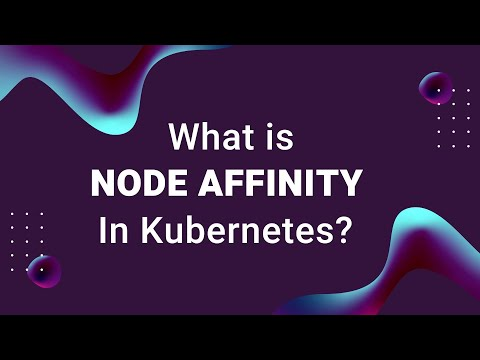

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('6ZHjqpn9dck')

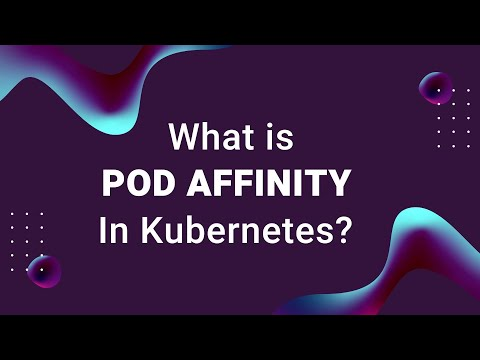

In [2]:
YouTubeVideo('S0ICBR_l9Es')

* [NodeSelector](#nodeselector)
* [Affinity and Anti-Affinity](#affinityanti)
* [More Practical Use-Cases](#practicalusecase)

<br><br>You can constrain a pod to only be able to run on particular nodes or to prefer to run on particular nodes

* Generally such contraints are unnecessary as the scheduler will automatically do a reasonable placement 
    * Spread your pods across nodes, not place the pod on a node with insufficient free resources 
    
* There are some circumstances where you may want more control on a node where a pod lands 
    * To ensure that a pod ends up on a machine with an SSD attached to it 
    * Co-locate pods from two different services that communicate a lot into the same availability zone 

## NodeSelector  

nodeSelector is the simplest recommended form of node selection constraint. 

* nodeSelector is a field of PodSpec. It specifies a map of key-value pairs 

For the pod to be eligible to run on a node the node must have each of the indicated key-value pairs as labels (it can have additional labels as well). 

The most common usage is one key-value pair 

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

#### <br><br>Attach a label to the node 

In [ ]:
!kubectl get nodes

* Lets pick one of the above and add a label to it 

In [ ]:
!kubectl label nodes ip-192-168-13-60.eu-west-1.compute.internal disktype=ssd 

In [ ]:
!kubectl get nodes --show-labels

#### <br><br>Add a nodeSelector field to your pod configuration

* Take whatever pod config file you want to run and add a nodeSelector to it. 

In [ ]:
!cat nodeSelector/pod-nginx.yaml

In [ ]:
!kubectl apply -f nodeSelector/pod-nginx.yaml

* verify that it worked 

In [ ]:
!kubectl get pods -o wide

* Keep note of the 'NODE' the pod was assigned to 

## <br><br>Affinity and Anti-Affinity 

<blockquote> nodeSelector provides a very simple way to constrain pods to nodes with particular labels. <br><Br>

The affinity/anti-affinity feature, currently in beta, greatly extends the types of constraints you can express 

* The key enhancements are 
    * The language is more expressive (not just 'AND of exact match') 
    * You can indicate that the rule is 'soft' or 'preference' rather than a hard requirement, so if the sceduler can't satisfy it the pod will still be scheduled 
    * You can constrain against labels on other pods running on the node (or other topological domain), rather than against labels on the node itself, which allows rules about which pods can and cannot be co-located 
    

* The affinity feature consists of two types of affinity 
    * node affinity 
        * This is like the existing nodeSelector (but with the first two benefits listed above)
    * inter-pod affinity/anti-affinity
        * Constrains against pod labels rather than node labels, as per the 3rd item in the list, in addition to having the first and second properties listed above. 
       

#### <br><br>Node Affinity (beta version) 

<blockquote> 
    
* Node affinity was introduced as alpha in Kubernetes 1.2 and is concepturally similar to nodeSelector 
* It allows you to constrain which nodes your pod is eligible to be scheduled on, based on labels on the node. 
* specified as field nodeAffinity of field affinity in the PodSpec <br><br>

   
* There are currently two types of node affinity <br><br>
    * <b>requiredDuringSchedulingIgnoredDuringExecution (hard)</b>
        * The rules that must be met for a pod to be scheduled onto a node 
        * Example: only run the pod on nodes with Intel CPUs<br><br>
    * <b>preferredDuringSchedulingIgnoredDuringExecution (soft)</b>
        * Scheduler will try and enforce but will not guarantee 
        * Example: try to run this set of pods in availability zone XYZ, but if it's not possible, then allow some to run elsewhere. <br><br>
        
The <b>'ignoredDuringExecution'</b> part of the name means that, similar to how nodeSelector works, if labels on a node change at runtime such that the affinity rules on a pod are no longer met, the pod will still continue to run on the node.

* We are going to create another label in the same node that we did in the last example

In [ ]:
!kubectl label nodes ip-192-168-13-60.eu-west-1.compute.internal azname=az1

* This is the spec to create the affinity


In [ ]:
!cat affinity/pod-with-node-affinity.yaml

<br><br>This node affinity rule says <b>the pod can only be placed on a node with a label whos key is azname and whos value is either az1 or az2 </b>

In addition, among nodes that meet that criteria, nodes with a label whose key is <b>'another-node-label-key'</b> and whos value is <b>'another-node-label-value'</b> should be preferred 

* Apply the config

In [ ]:
!kubectl apply -f affinity/pod-with-node-affinity.yaml

 * Check if it worked

In [ ]:
!kubectl get pods -o wide 

* Lets try put the affinity in another node and put the label on a different node. 

* First clean the label and delete the pod 

In [ ]:
!kubectl delete -f affinity/pod-with-node-affinity.yaml
!kubectl label nodes ip-192-168-13-60.eu-west-1.compute.internal azname-

* Get Nodes to apply 

In [ ]:
!kubectl get nodes

* We are putting the label to the node

In [ ]:
!kubectl label nodes ip-192-168-13-60.eu-west-1.compute.internal azname=az1
!kubectl apply -f affinity/pod-with-node-affinity.yaml

* check if it works 

In [ ]:
!kubectl get pods -o wide

<blockquote> 

You can see the operating in being used in the example 

* The new node affinity syntax supports the following operators 
    * In 
    * NotIn --> Anti-Affinity Behavior
    * Exists
    * DoesNotExist --> Anti-Affinity Behavior
    * Gt
    * Lt 
<br><br>

If you specify both <b>'nodeSelector'</b> and <b>'nodeAffinity'</b>
* Both must satisfy for the pod to be scheduled onto a candidate node <br><br>

If you specify multiple <b>'nodeSelectorTerms'</b> associated with <b>'nodeAffinity'</b> types
* The pod can be scheduled onto a node if one of the 'NodeSelectorTerms' is satisfied <br><br>

If you specify multiple <b>'matchExpressions'</b> associated with <b>'nodeSelectorTerms'</b> 
* The pod can be scheduled onto a node only if all 'matchExpressions' can be satisfied<br><br>


If you remove or change the label of the node where the pod is scheduled
* The pod wont be removed. 
* The affinity selection works only at the time of scheduling the pod. <br><br>


The weight field in <b>'preferredDuringSchedulingIgnoredDuringExecution'</b> is in the range 1-100. 

For each node that meets all the scheduling requirements, the scheduler will compute a sum by iterating through the elements of this field and adding <b>'weight'</b> to the sum if the node matches the corresponding <b>'MatchExpressions'</b>. This score is then combined with the scores of other priority functions for the node. The node(s) with the highest total score are the most preferred
    

## <br><br> More Practical Use-Cases 

More practical use-cases AntiAffinity can be even more useful when they are used with high level collections such as ReplicaSets, StatefulSets, Deployments, etc. 

One can easily configure that a set of workloads should be co-located in the same defined topology e.g. the same node

#### <br><br>Always co-located in the same node

In a three node cluster, a web application has in-memory cache such as redis. We want the web-servers to be co-located with the cache as much as possible 

* This is the yaml of a simple redis deployment with three replicas and selector label app=store. The deployment has PodAntiAffinity configured to ensure the scheduler does not co-locate replicas on a single node. 

In [ ]:
!cat affinity/redis-with-node-affinity.yaml

<br><br>* The yaml snippet of the webserver deployment has podAntiAffinity and podAffinity configured. This informs the scheduler that all its replicas are to be co-located with pods that have selector label app=store. This will also ensure that each web-server replica does not co-locate on a single node. 

In [ ]:
!cat affinity/web-with-node-affinity.yaml

<br><br>* Lets apply this Deployments

In [ ]:
!kubectl apply -f affinity/redis-with-node-affinity.yaml
!kubectl apply -f affinity/web-with-node-affinity.yaml 

* Here you can see the 3 replicas of the web-server are automatically co-located with the cache as expected

In [ ]:
!kubectl get pods -o wide

## <br><br> Clean Up

In [ ]:
%%bash

kubectl delete -f nodeSelector/pod-nginx.yaml 
kubectl delete -f affinity/pod-with-node-affinity.yaml
kubectl delete -f affinity/redis-with-node-affinity.yaml
kubectl delete -f affinity/web-with-node-affinity.yaml

In [ ]:
!kubectl label nodes ip-192-168-13-60.eu-west-1.compute.internal azname-

<br><br>
<center>
<h1 style="background:black">
<code style="background:black;color:white">
Using Spot Instances with EKS
</code>
</h1>
</center>


<div class="alert alert-block alert-warning">
<font style="color:black">
<center>Provision, manage and maintain Kubernetes clusters with EKS at any scale on Spot instances to optimise cost and scale </center></font></div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/23.jpg" width="40%" height="40%" border=5/></center>

## Add EC2 Spot Workers 

We currently have worker nodes already, but we need to add some spot instances configured as workers. <br><br>We also need a Node Labeling strategy to identify which instances are spot and which are on-demand so that we can make more intelligence scheduling decisions.<br><br> We will use eksctl to launch new worker nodes that will connect to the EKS cluster 

* Add a new label to the OnDemand worker nodes 

In [ ]:
!kubectl label nodes --all 'lifecycle=OnDemand'

#### <br><br>Create Spot Worker Nodes

* We are now ready to create new worker nodes

In [ ]:
!eksctl create nodegroup -f spot-instances/eks-workshop-ng-spot.yaml

<blockquote>During the creation of the Node Group, we have configured a <b>node-label</b> so that kubernetes knows what type of nodes we have provisioned

* We set the <b>lifecycle</b> for the nodes as <b>EC2Spot</b>

* We are also tainting with <b>'PreferNoSchedule'</b> to prefer pods not be scheduled on Spot Instances 
    * This is the preference version of <b>'NoSchedule'</b> 
    * The system will try to avoid placing a pod that does not tolerate the taint on the node, but it is not required 
  
  
* We specified capacity-optimised as the <b>spotAllocationStrategy</b>, which will launch instances from the Spot Instance pools with the most available capacity (out of the instnace types we specified), aiming to decrease the number of Spot interruptions in our cluster (when EC2 needs the capacity back) 

#### <br><br> Confirm the Nodes 

* Check the timestamps

In [ ]:
!kubectl get nodes --sort-by=.metadata.creationTimestamp 

* You can use the node-labels to identify the lifecycle of the nodes

In [ ]:
!kubectl get nodes --label-columns=lifecycle --selector=lifecycle=Ec2Spot 

* The output of the command should return 2 nodes. At the end of the node output, you should see the node label <b>lifecycle=Ec2Spot</b>

* We can show all nodes with the <b>lifecycle=OnDemand</b>. The output of this command should return multiple nodes as configured in eksctl YAML template 

In [ ]:
!kubectl get nodes --label-columns=lifecycle --selector=lifecycle=OnDemand

* You can use the kubectl describe nodes with one of the spot nodes to see the taints applied to the EC2 Spot Instances

In [ ]:
!kubectl describe nodes 

* Use the kubectl describe nodes with one of the spot nodes to see the taints applied to the EC2 Spot Instances.
    * <b>Taints: spotInstance=true:PreferNoSchedule </b>

## <br><br>  Deploy the AWS Node Termination Handler

<blockquote>In this section we will prepare our cluster to handle Spot interruptions

Demand for Spot instances can vary significantly, and as a consequence the availability of Spot Instances will also vary depending on how many unused EC2 instances are available. It is always possible that your Spot instance might be interrupted. In this case the Spot instances are sent an interruption notice two minutes ahead to gracefully wrap up things. We will deploy a pod on each spot instance to detect and redeploy applications. 

The first thing we need to do is deploy the AWS Node Termination Handler on each Spot Instance. This will monitor the EC2 metadata service on the instance for an interruption notice. The termination handler consists of:
* ServiceAccount
* ClusterRole
* ClusterRoleBinding
* DaemonSet 
        
The workflow can be summarised as:
* Identify that a spot instance is being reclaimed 
* Use the 2 minute notification window to gracefully prepare the node for termination 
* Taint the node and cordon it off to prevent new pods from being placed 
* Drain connections on the running pods 
* Replace the pods on remaining nodes to maintain the desired capacity 
    
By default, the <b>aws-node-termination-handler</b> will run on all of your nodes (on-demand and spot). 

* If your spot instances are labeled, you can configure <b>'aws-node-termination-handler'</b> to only run on your labeled spot nodes. 

* If using the tag <b>'lifecycle=Ec2Spot'</b>, you can run the following to apply our spot-node-selector overlay. 

In [ ]:
%%bash 

helm repo add eks https://aws.github.io/eks-charts

helm upgrade --install aws-node-termination-handler \
             --namespace kube-system \
             --set nodeSelector.lifecycle=Ec2Spot \
              eks/aws-node-termination-handler


* Verify that the pods are only running on node with label lifecycle=Ec2Spot

In [ ]:
!kubectl --namespace=kube-system get daemonsets 

* We care about this line

## <br><br> Deploy an application on spot

We are redesigning our Microservices example and want our frontend service to be deployed on Spot Instances when they are available. 

We will use Node Affinity in our manifest file to configure this

#### <br><br> Configure Node Affinity and Tolerations 

* In this following spec we have NodeAffinity to <b>prefer</b> Spot Instances, but not <b> require</b> them. This will allow the pods to be scheduled On-Demand nodes if no spot instances were available or correctly labelled. 

* We also want to configure toleration which will allow the pods to 'tolerate' the taint that we configured on our EC2 Spot Instances. 

In [ ]:
!cat ecsdemo-frontend/kubernetes/deployment-spot.yaml 

#### <br><br>Redeploy the Frontend on Spot

* First lets look at all pods deployed on Spot instances

In [ ]:
%%bash
for n in $(kubectl get nodes -l lifecycle=Ec2Spot --no-headers | cut -d " " -f1); \
do echo "Pods on instance ${n}:"; \
kubectl get pods --all-namespaces  --no-headers --field-selector spec.nodeName=${n} ; echo ; done

* Now we will redeploy our microservices with our edited Frontend Manifest 

In [ ]:
%%bash

kubectl apply -f ecsdemo-frontend/kubernetes/service.yaml
kubectl apply -f ecsdemo-frontend/kubernetes/deployment-spot.yaml

kubectl apply -f ecsdemo-crystal/kubernetes/service.yaml
kubectl apply -f ecsdemo-crystal/kubernetes/deployment.yaml

kubectl apply -f ecsdemo-nodejs/kubernetes/service.yaml
kubectl apply -f ecsdemo-nodejs/kubernetes/deployment.yaml

* We can again check all pods deployed on Spot Instances and should now see the frontend pods running on Spot Instances

In [ ]:
%%bash
for n in $(kubectl get nodes -l lifecycle=Ec2Spot --no-headers | cut -d " " -f1); \
do echo "Pods on instance ${n}:"; \
kubectl get pods --all-namespaces  --no-headers --field-selector spec.nodeName=${n} ; echo ; done

## <br><br>Cleanup 

In [ ]:
%%bash

kubectl delete -f ecsdemo-frontend/kubernetes/service.yaml
kubectl delete -f ecsdemo-frontend/kubernetes/deployment-spot.yaml

kubectl delete -f ecsdemo-crystal/kubernetes/service.yaml
kubectl delete -f ecsdemo-crystal/kubernetes/deployment.yaml

kubectl delete -f ecsdemo-nodejs/kubernetes/service.yaml
kubectl delete -f ecsdemo-nodejs/kubernetes/deployment.yaml

* Cleanup the AWS node termination handler daemonset 

In [ ]:
!helm uninstall aws-node-termination-handler --namespace=kube-system

* delete the label and the Node Group created by this module

In [ ]:
!kubectl label nodes --all lifecycle- 
!eksctl delete nodegroup -f spot-instances/eks-workshop-ng-spot.yaml --approve 